# 1. Create the data.yaml file

In [1]:
%%writefile /kaggle/working/data.yaml

train: /kaggle/input/solid-waste-detection/Solidwaste-Detection/Solidwaste-Detection/train/images
val: /kaggle/input/solid-waste-detection/Solidwaste-Detection/Solidwaste-Detection/val/images
test: /kaggle/input/solid-waste-detection/Solidwaste-Detection/Solidwaste-Detection/test/images

nc: 2

names: ['Bottle', 'Cans']

Writing /kaggle/working/data.yaml


# 2. Setup

In [2]:
!pip install ultralytics --no-deps

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 14.2 MB/s eta 0:00:00


In [3]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
import yaml, json, os, random, cv2, glob
import numpy as np
from pathlib import Path
import pandas as pd

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


# 3. Dataset Configuration

In [4]:
DATASET_ROOT = '/kaggle/input/solid-waste-detection/Solidwaste-Detection/Solidwaste-Detection'
IMAGES_TRAIN = os.path.join(DATASET_ROOT, 'train', 'images')
IMAGES_VAL = os.path.join(DATASET_ROOT, 'val', 'images')
IMAGES_TEST = os.path.join(DATASET_ROOT, 'test', 'images')

LABELS_TRAIN = os.path.join(DATASET_ROOT, 'train', 'labels')
LABELS_VAL = os.path.join(DATASET_ROOT, 'val', 'labels')
LABELS_TEST = os.path.join(DATASET_ROOT, 'test', 'labels')

CLASS_NAMES = ['Bottle', 'Cans']

# 3. Validate Dataset Integrity

In [5]:
def validate_images(img_dir, label_dir, max_check=100):
    """Check for corrupted images and remove them with their labels."""
    img_files = glob.glob(os.path.join(img_dir, "*.*"))
    img_files = [f for f in img_files if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]
    
    corrupted = []
    print(f"Checking {min(max_check, len(img_files))} images in {img_dir}...")
    
    for i, img_path in enumerate(img_files[:max_check]):
        try:
            img = cv2.imread(img_path)
            if img is None:
                corrupted.append(img_path)
                print(f"Corrupted: {os.path.basename(img_path)}")
        except Exception as e:
            corrupted.append(img_path)
            print(f"Error reading {os.path.basename(img_path)}: {e}")
    
    print(f"Found {len(corrupted)} corrupted images out of {min(max_check, len(img_files))} checked")
    return corrupted

print("=" * 60)
print("VALIDATING DATASET")
print("=" * 60)
corrupted_train = validate_images(IMAGES_TRAIN, LABELS_TRAIN, max_check=100)
corrupted_val = validate_images(IMAGES_VAL, LABELS_VAL, max_check=50)

VALIDATING DATASET
Checking 100 images in /kaggle/input/solid-waste-detection/Solidwaste-Detection/Solidwaste-Detection/train/images...
Found 0 corrupted images out of 100 checked
Checking 50 images in /kaggle/input/solid-waste-detection/Solidwaste-Detection/Solidwaste-Detection/val/images...
Found 0 corrupted images out of 50 checked


# 4. Create data.yaml

In [6]:
yaml_path = '/kaggle/working/data.yaml'
DATA_YAML = {
    'path': DATASET_ROOT,
    'train': 'train/images',
    'val': 'val/images',
    'test': 'test/images',
    'nc': 2,
    'names': CLASS_NAMES
}

with open(yaml_path, 'w') as f:
    yaml.dump(DATA_YAML, f)

print("\n" + "=" * 60)
print("DATA CONFIGURATION")
print("=" * 60)
print(f"YAML path: {yaml_path}")
print(f"Train images exist: {os.path.exists(IMAGES_TRAIN)}")
print(f"Val images exist: {os.path.exists(IMAGES_VAL)}")
print(f"Test images exist: {os.path.exists(IMAGES_TEST)}")


DATA CONFIGURATION
YAML path: /kaggle/working/data.yaml
Train images exist: True
Val images exist: True
Test images exist: True


# 5. Train YOLOv12n (Segmentation)

In [7]:
model = YOLO('yolo12n-seg.yaml').load("yolo12n.pt")

print("\n" + "=" * 60)
print("STARTING TRAINING")
print("=" * 60)

try:
    results = model.train(
        data=yaml_path,
        epochs=50,            
        imgsz=640,
        batch=8,              
        workers=2,
        device=0,             
        patience=10,        
        save=True,
        save_period=-1,       
        pretrained=True,
        optimizer="auto",
        project="/kaggle/working/yolo12_runs",
        name="detect_yolo12_seg",
        exist_ok=True,
        amp=True  
    )
    print("\nTraining completed successfully!")
    print(f"Results saved to: {results.save_dir}")
except Exception as e:
    print(f"\nTraining failed with error:")
    print(f"{type(e).__name__}: {e}")
    raise

Transferred 691/753 items from pretrained weights

STARTING TRAINING
Ultralytics 8.3.223 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo12n-seg.yaml, momentum=0.937, mosaic=1.0, multi_scale=False, name=detect_yolo12_seg, nbs=64, nms=False, opset=None, optimize=

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       1474       1639      0.947      0.877      0.944      0.838       0.95      0.881      0.942      0.822
                Bottle        829       1072      0.947      0.804      0.908      0.775      0.948      0.805      0.902      0.742
                  Cans        527        567      0.947      0.951       0.98      0.902      0.952      0.956      0.981      0.902
Speed: 0.2ms preprocess, 4.1ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to /kaggle/working/yolo12_runs/detect_yolo12_seg

Training completed successfully!
Results saved to: /kaggle/working/yolo12_runs/detect_yolo12_seg


# 6. Validation & Loss-curve

In [8]:
print("\n" + "=" * 60)
print("VALIDATION METRICS")
print("=" * 60)

run_dir = results.save_dir if hasattr(results, "save_dir") else "/kaggle/working/yolo12_runs/detect_yolo12_seg"
best_ckpt = os.path.join(run_dir, "weights", "best.pt")

if os.path.exists(best_ckpt):
    print(f"Loading best weights: {best_ckpt}")
    model = YOLO(best_ckpt)
    
    val_metrics = model.val(split="val")
    
    print(f"\nValidation Results:")
    print(f"  Box mAP50-95: {val_metrics.box.map:.4f}")
    print(f"  Box mAP50: {val_metrics.box.map50:.4f}")
    print(f"  Mask mAP50-95: {val_metrics.seg.map:.4f}")
    print(f"  Mask mAP50: {val_metrics.seg.map50:.4f}")
else:
    print("Best checkpoint not found!")


VALIDATION METRICS
Loading best weights: /kaggle/working/yolo12_runs/detect_yolo12_seg/weights/best.pt
Ultralytics 8.3.223 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO12n-seg summary (fused): 172 layers, 2,809,534 parameters, 0 gradients
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 45.2±32.8 MB/s, size: 27.5 KB)
val: Scanning /kaggle/input/solid-waste-detection/Solidwaste-Detection/Solidwaste-Detection/val/labels... 1474 images, 220 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1474/1474 769.6it/s 1.9s
WARNING ⚠️ val: Cache directory /kaggle/input/solid-waste-detection/Solidwaste-Detection/Solidwaste-Detection/val is not writable, cache not saved.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 93/93 6.0it/s 15.6s


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       1474       1639      0.947      0.878      0.944      0.839       0.95      0.881      0.942      0.822
                Bottle        829       1072      0.947      0.804      0.908      0.775      0.948      0.806      0.902      0.742
                  Cans        527        567      0.947      0.951       0.98      0.903      0.952      0.956      0.981      0.902
Speed: 1.2ms preprocess, 4.2ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to /kaggle/working/runs/segment/val

Validation Results:
  Box mAP50-95: 0.8390
  Box mAP50: 0.9439
  Mask mAP50-95: 0.8220
  Mask mAP50: 0.9415


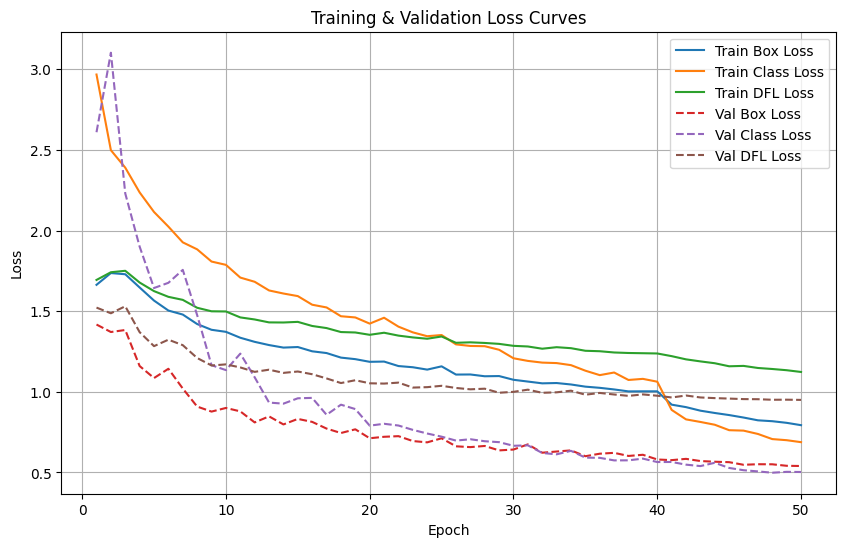

In [9]:
results_dir = '/kaggle/working/yolo12_runs/detect_yolo12_seg'

results_csv = os.path.join(results_dir, "results.csv")
results = pd.read_csv(results_csv)

# Plot key losses
plt.figure(figsize=(10, 6))
plt.plot(results["epoch"], results["train/box_loss"], label="Train Box Loss")
plt.plot(results["epoch"], results["train/cls_loss"], label="Train Class Loss")
plt.plot(results["epoch"], results["train/dfl_loss"], label="Train DFL Loss")
plt.plot(results["epoch"], results["val/box_loss"], '--', label="Val Box Loss")
plt.plot(results["epoch"], results["val/cls_loss"], '--', label="Val Class Loss")
plt.plot(results["epoch"], results["val/dfl_loss"], '--', label="Val DFL Loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss Curves")
plt.legend()
plt.grid(True)
plt.show()

# 7. Test set evaluation

In [10]:

print("\n" + "=" * 60)
print("TEST INFERENCE")
print("=" * 60)
    
test_img_dir = os.path.join(DATASET_ROOT, 'test', 'images')
test_imgs = glob.glob(os.path.join(test_img_dir, '*.*'))
test_imgs = [f for f in test_imgs if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
if len(test_imgs) > 0:
    sample_imgs = random.sample(test_imgs, min(6, len(test_imgs)))
        
    print(f"Running inference on {len(sample_imgs)} test images...")
    predictions = model.predict(
        source=sample_imgs,
        imgsz=640,
        conf=0.25,
        verbose=False,
        save=False
    )
        


TEST INFERENCE
Running inference on 6 test images...


# 8. Visualization Functions

In [11]:
def draw_gt_polygons(img_path, label_path, class_names):
    """Draw ground truth segmentation polygons."""
    img = cv2.imread(img_path)
    if img is None:
        return None
    
    h, w = img.shape[:2]
    overlay = img.copy()

    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            for line in f:
                vals = list(map(float, line.strip().split()))
                cls_id = int(vals[0])
                coords = vals[1:]
                
                if len(coords) > 4:
                    pts = np.array(coords).reshape(-1, 2)
                    pts[:, 0] *= w
                    pts[:, 1] *= h
                    pts = pts.astype(np.int32)
                    
                    color = (0, 255, 0)  # Green for GT
                    cv2.fillPoly(overlay, [pts], color)
                    cv2.polylines(overlay, [pts], True, (255, 255, 255), 2)
                    
                    label = class_names[cls_id] if cls_id < len(class_names) else str(cls_id)
                    cv2.putText(overlay, f"GT: {label}", (pts[0][0], pts[0][1] - 10),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
    
    return cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)

def draw_pred_polygons(result):
    """Draw predicted segmentation polygons."""
    img = result.orig_img.copy()

    if hasattr(result, 'masks') and result.masks is not None:
        for i, seg in enumerate(result.masks.xy):
            poly = np.array(seg, dtype=np.int32)
            color = (0, 0, 255)  # Red for predictions
            cv2.fillPoly(img, [poly], color)
            cv2.polylines(img, [poly], True, (255, 255, 255), 2)
            
            if hasattr(result, 'boxes') and result.boxes.cls is not None:
                cls_id = int(result.boxes.cls[i].item())
                conf = float(result.boxes.conf[i].item())
                label = result.names.get(cls_id, str(cls_id))
                x, y = poly[0]
                cv2.putText(img, f"{label} {conf:.2f}", (int(x), int(y) - 6),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
    
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# 9. Predict and Visualize on Test Set


PREDICTION AND VISUALIZATION
Running inference on 4 test images...


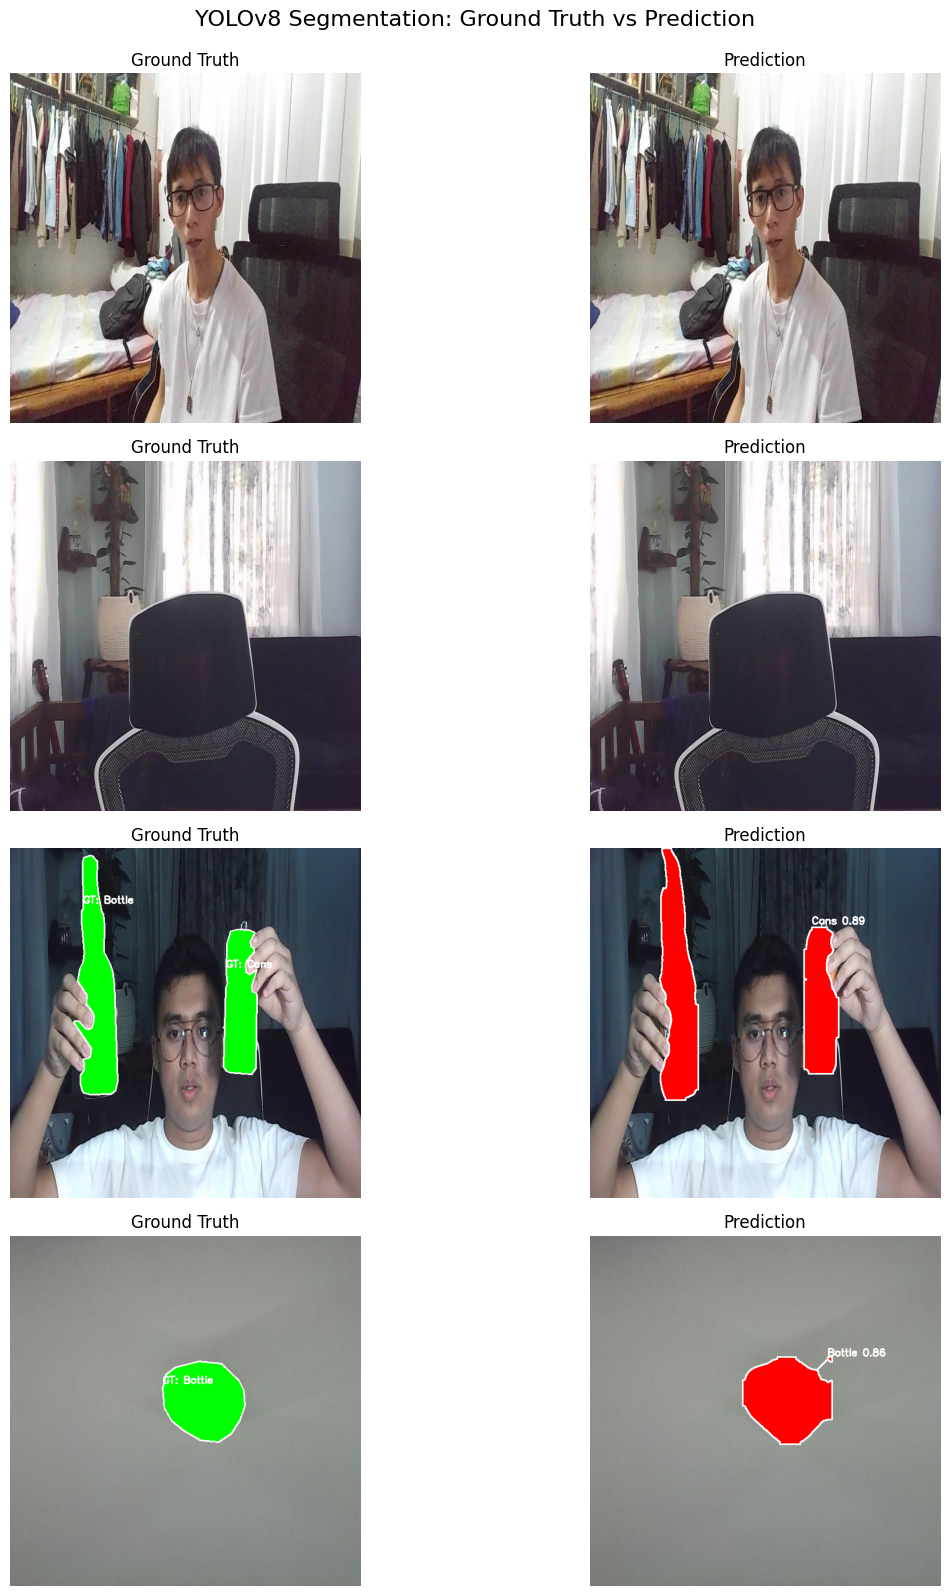


All done!


In [12]:
print("\n" + "=" * 60)
print("PREDICTION AND VISUALIZATION")
print("=" * 60)

test_imgs = glob.glob(os.path.join(IMAGES_TEST, "*.*"))
test_imgs = [f for f in test_imgs if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
sample_imgs = random.sample(test_imgs, min(4, len(test_imgs)))

print(f"Running inference on {len(sample_imgs)} test images...")
preds = model.predict(source=sample_imgs, imgsz=640, conf=0.25, save=False, verbose=False)

fig, axes = plt.subplots(len(preds), 2, figsize=(14, 4 * len(preds)))
if len(preds) == 1:
    axes = axes.reshape(1, -1)

for i, result in enumerate(preds):
    img_path = result.path
    label_path = os.path.join(LABELS_TEST, 
                              os.path.basename(img_path).rsplit('.', 1)[0] + '.txt')
    
    vis_gt = draw_gt_polygons(img_path, label_path, CLASS_NAMES)
    vis_pred = draw_pred_polygons(result)
    
    axes[i, 0].imshow(vis_gt)
    axes[i, 0].set_title("Ground Truth", fontsize=12)
    axes[i, 0].axis('off')
    
    axes[i, 1].imshow(vis_pred)
    axes[i, 1].set_title("Prediction", fontsize=12)
    axes[i, 1].axis('off')

plt.suptitle("YOLOv8 Segmentation: Ground Truth vs Prediction", fontsize=16, y=0.995)
plt.tight_layout()
plt.show()

print("\nAll done!")